In [1]:
import os
import random
import time
import torch
from torch.utils.data import DataLoader

from evaluate import evaluate
from models.losses import log_likelihood
from models.metrics import SpanEvaluator
from utils.dataset import CustomDataset
from models.collate import collate_fn, gold_labels
import numpy as np
from models.model import SpanAsteModel
from utils.processor import Res15DataProcessor
from utils.tager import SpanLabel
from utils.tager import RelationLabel
from transformers import BertTokenizer, get_linear_schedule_with_warmup

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print(f"using device:{device}")


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

using device:cuda


In [3]:
args = {
    'bert_model': 'bert-base-uncased',
    'span_pruned_threshold': 0.5,
    'batch_size': 1,
    'learning_rate': 5e-5,
    'weight_decay': 1e-2,
    'warmup_proportion': 0.1,
    'train_path': 'data/15res',
    'dev_path': 'data/15res',
    'save_dir': './checkpoint',
    'max_seq_len': 16,
    'num_epochs': 10,
    'seed': 41,
    'logging_steps': 30,
    'valid_steps': 50,
    'init_from_ckpt': 'checkpoint\model_best\model.pt'
}

args = type('allMyFields', (object,), args)

# set seed
set_seed(args.seed)

In [4]:
# get dimension of target and relation
target_dim, relation_dim = len(SpanLabel), len(RelationLabel)
# build span-aste model
model = SpanAsteModel(
    args.bert_model,
    target_dim,
    relation_dim,
    span_pruned_threshold=args.span_pruned_threshold,
    device=device
)
model.to(device)

SpanAsteModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

### **DataLoader**

In [5]:
# tokenizer
tokenizer = BertTokenizer.from_pretrained(args.bert_model)

# create processor
processor = Res15DataProcessor(tokenizer, args.max_seq_len)

print("Loading Train & Eval Dataset...")
# Load dataset
train_dataset = CustomDataset("train", args.train_path, processor, tokenizer, args.max_seq_len)
eval_dataset = CustomDataset("dev", args.dev_path, processor, tokenizer, args.max_seq_len)
test_dataset = CustomDataset("test", args.dev_path, processor, tokenizer, args.max_seq_len)

print("Construct Dataloader...")
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)
eval_dataloader = DataLoader(eval_dataset, batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, collate_fn=collate_fn)

Loading Train & Eval Dataset...
Construct Dataloader...


#### **Visualize**

In [6]:
vars(train_dataset.examples[0])

{'guid': 'train-0',
 'text_a': 'Judging from previous posts this used to be a good place , but not any longer .',
 'spans': [(11, 12), (10, 11)],
 'relations': [(11, 12, 10, 11)],
 'span_labels': [1, 2],
 'relation_labels': [2]}

In [7]:
dataset = []
dataset.extend(train_dataset.examples)
dataset.extend(eval_dataset.examples)
dataset.extend(test_dataset.examples)

len(dataset)

1075

### **Train**

#### **Setup**

In [8]:
no_decay = ['bias', 'LayerNorm.weight']
bert_param_optimizer = list(model.bert.named_parameters())
span_linear_param_optimizer = list(model.span_ffnn.named_parameters())
pair_linear_param_optimizer = list(model.pairs_ffnn.named_parameters())
optimizer_grouped_parameters = [
    {'params': [p for n, p in bert_param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay': args.weight_decay, 'lr': args.learning_rate},
    {'params': [p for n, p in bert_param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0,
        'lr': args.learning_rate},

    {'params': [p for n, p in span_linear_param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay': 0.0, 'lr': 1e-3},
    {'params': [p for n, p in span_linear_param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0,
        'lr': 1e-3},

    {'params': [p for n, p in pair_linear_param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay': 0.0, 'lr': 1e-3},
    {'params': [p for n, p in pair_linear_param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0,
        'lr': 1e-3}
]


optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=args.learning_rate)
num_training_steps = len(train_dataloader) * args.num_epochs
num_warmup_steps = num_training_steps * args.warmup_proportion
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps,
                                            num_training_steps=num_training_steps)


metric = SpanEvaluator()

#### **Train loop**

In [9]:
best_f1 = 0

for epoch in range(1, args.num_epochs + 1):
    model.train()
    tic_train = time.time()
    loss_list = []

    for batch_ix, batch in enumerate(train_dataloader):
        input_ids, attention_mask, token_type_ids, spans, relations, span_labels, relation_labels, seq_len = batch
        input_ids = torch.tensor(input_ids, device=device)
        attention_mask = torch.tensor(attention_mask, device=device)
        token_type_ids = torch.tensor(token_type_ids, device=device)

        # forward
        spans_probability, span_indices, relations_probability, candidate_indices = model(
            input_ids, attention_mask, token_type_ids, seq_len)

        gold_span_indices, gold_span_labels = gold_labels(span_indices, spans, span_labels)
        loss_ner = log_likelihood(spans_probability, span_indices, 
                                  gold_span_indices, gold_span_labels, invalid_rate=0.001)

        gold_relation_indices, gold_relation_labels = gold_labels(candidate_indices, relations, relation_labels)
        loss_relation = log_likelihood(relations_probability, candidate_indices, 
                                       gold_relation_indices, gold_relation_labels, invalid_rate=0.01)

        # loss compute
        loss = loss_ner + loss_relation

        # backward
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        scheduler.step()

        loss_list.append(float(loss))
        
        if batch_ix % 50 == 0:
            print("Batch: %d, loss: %.5f" % (batch_ix, sum(loss_list) / len(loss_list)))

    time_diff = time.time() - tic_train
    loss_avg = sum(loss_list) / len(loss_list)

    print("Epoch: %d, loss: %.5f, time: %d seconds"% (epoch, loss_avg, time_diff))

    #eval
    precision, recall, f1 = evaluate(model, metric, eval_dataloader, device)
    print("Evaluation precision: %.5f, recall: %.5f, F1: %.5f" % (precision, recall, f1))

    if f1 > best_f1:
        print(f"best F1 performence has been updated: {best_f1:.5f} --> {f1:.5f}")
        best_f1 = f1
        save_dir = os.path.join(args.save_dir, "model_best")
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        torch.save(model.state_dict(), os.path.join(save_dir, "model_v3.pt"))
    print()

Batch: 0, loss: 19.90731
Batch: 50, loss: 42.57596
Batch: 100, loss: 27.82110
Batch: 150, loss: 22.39578
Batch: 200, loss: 19.74555
Batch: 250, loss: 18.19354
Batch: 300, loss: 17.19445
Batch: 350, loss: 16.23532
Batch: 400, loss: 15.22645
Batch: 450, loss: 14.60579
Batch: 500, loss: 13.85350
Batch: 550, loss: 13.31222
Batch: 600, loss: 12.92586
Epoch: 1, loss: 12.87240, time: 132 seconds
Evaluation precision: 0.50704, recall: 0.20112, F1: 0.28800
best F1 performence has been updated: 0.00000 --> 0.28800

Batch: 0, loss: 0.09322
Batch: 50, loss: 5.73955
Batch: 100, loss: 6.76871
Batch: 150, loss: 6.71798
Batch: 200, loss: 6.39407
Batch: 250, loss: 6.44129
Batch: 300, loss: 6.33536
Batch: 350, loss: 6.16447
Batch: 400, loss: 6.11092
Batch: 450, loss: 5.84786
Batch: 500, loss: 5.72948
Batch: 550, loss: 5.76593
Batch: 600, loss: 5.76346
Epoch: 2, loss: 5.77064, time: 130 seconds
Evaluation precision: 0.72857, recall: 0.28022, F1: 0.40476
best F1 performence has been updated: 0.28800 --> 0

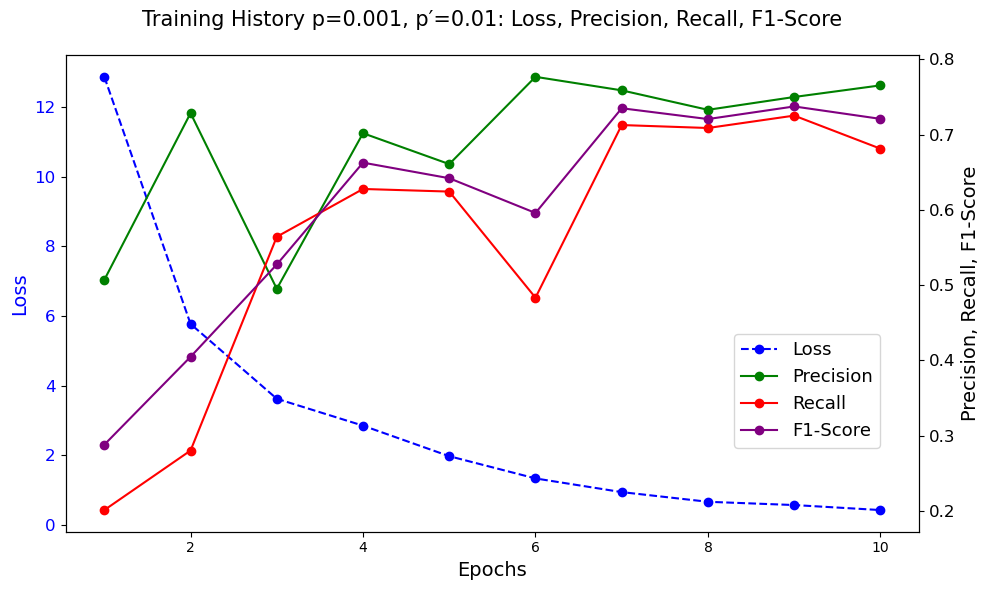

In [27]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, 11) 
loss =      [12.8724, 5.77064, 3.62112, 2.847798, 1.97058, 1.33151, 0.93845, 0.66034, 0.56677, 0.42255]
precision = [0.50704, 0.72857, 0.49510, 0.70186, 0.66082, 0.77679, 0.75882, 0.73295, 0.75000, 0.76543]
recall =    [0.20112, 0.28022, 0.56425, 0.62778, 0.62431, 0.48333, 0.71271, 0.70879, 0.72527, 0.68132]
f1_score =  [0.28800, 0.40476, 0.52742, 0.66276, 0.64205, 0.59589, 0.73504, 0.72067, 0.73743, 0.72093]

# Tạo đồ thị chính
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(epochs, loss, marker='o', color='b', label='Loss', linestyle='--')
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Loss', color='b', fontsize=14)
ax1.tick_params(axis='y', labelcolor='b', labelsize=12)

# Tạo trục y thứ hai (twinx)
ax2 = ax1.twinx()
ax2.plot(epochs, precision, marker='o', color='g', label='Precision')
ax2.plot(epochs, recall, marker='o', color='r', label='Recall')
ax2.plot(epochs, f1_score, marker='o', color='purple', label='F1-Score')
ax2.set_ylabel('Precision, Recall, F1-Score', color='black', fontsize=14)
ax2.tick_params(axis='y', labelcolor='black', labelsize=12)

# Thêm tiêu đề và chú thích
plt.title('Training History p=0.001, p′=0.01: Loss, Precision, Recall, F1-Score', fontsize=15, pad=21)
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.73, 0.45), fontsize=13)
plt.show()


### **Eval**

In [10]:
model.load_state_dict(torch.load('checkpoint\model_best\model_v3.pt', weights_only=True))
model.eval()

precision, recall, f1 = evaluate(model, metric, eval_dataloader, device)
print("Evaluation precision: %.5f, recall: %.5f, F1: %.5f" % (precision, recall, f1))

Evaluation precision: 0.75000, recall: 0.72527, F1: 0.73743


In [11]:
precision, recall, f1 = evaluate(model, metric, test_dataloader, device)
print("Evaluation precision: %.5f, recall: %.5f, F1: %.5f" % (precision, recall, f1))

Evaluation precision: 0.66082, recall: 0.66864, F1: 0.66471


In [12]:
from sklearn.metrics import classification_report, confusion_matrix

def test_report(model_test:SpanAsteModel):
    spans_predicts = np.array([])
    spans_labels = np.array([])
    triple_predicts = np.array([])
    triple_lables = np.array([])

    candidate_indices_list = []
    relations_list = []

    with torch.no_grad():
        for batch_ix, batch in enumerate(test_dataloader):
            input_ids, attention_mask, token_type_ids, spans, relations, span_labels, relation_labels, seq_len = batch
            input_ids = torch.tensor(input_ids, device=device)
            attention_mask = torch.tensor(attention_mask, device=device)
            token_type_ids = torch.tensor(token_type_ids, device=device)

            # forward
            spans_probability, span_indices, relations_probability, candidate_indices = model_test(
                input_ids, attention_mask, token_type_ids, seq_len)

            gold_span_indices, gold_span_labels = gold_labels(span_indices, spans, span_labels)
            gold_relation_indices, gold_relation_labels = gold_labels(candidate_indices, relations, relation_labels)


            spans_predicts = np.concatenate((spans_predicts, torch.flatten(spans_probability.argmax(-1)).cpu().numpy()))
            spans_labels = np.concatenate((spans_labels, np.array(gold_span_labels).flatten()))

            triple_predicts = np.concatenate((triple_predicts, torch.flatten(relations_probability.argmax(-1)).cpu().numpy()))
            triple_lables = np.concatenate((triple_lables, np.array(gold_relation_labels).flatten()))

            candidate_indices_list.extend(candidate_indices)
            relations_list.extend(relations)


    print('spans_labels:')
    print(classification_report(spans_labels, spans_predicts))

    print('triple_lables:')
    print(classification_report(triple_lables, triple_predicts, zero_division=1))

    recall = 0
    total = 0

    for i in range(len(relations_list)):
        total += len(relations_list[i])
        for j in range(len(relations_list[i])):
            if relations_list[i][j] in candidate_indices_list[i]:
                recall += 1

    print("Eval pruning strategy:")
    print("Candidates: %d - N_triple: %d - Recall: %.5f" % (recall, total, recall / total))

In [13]:
torch.cuda.empty_cache()

In [14]:
model_v1 = SpanAsteModel(args.bert_model, target_dim, relation_dim,
                         span_pruned_threshold=args.span_pruned_threshold, device=device)
model_v1.to(device)
model_v1.load_state_dict(torch.load('checkpoint\model_best\model.pt', weights_only=True))
model_v1.eval()
test_report(model_v1)

spans_labels:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     24956
         1.0       0.82      0.83      0.82       349
         2.0       0.80      0.85      0.82       363

    accuracy                           0.99     25668
   macro avg       0.87      0.89      0.88     25668
weighted avg       0.99      0.99      0.99     25668

triple_lables:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     14870
         1.0       0.77      0.70      0.73       234
         2.0       0.59      0.46      0.52        89
         3.0       1.00      0.00      0.00        18

    accuracy                           0.99     15211
   macro avg       0.84      0.54      0.56     15211
weighted avg       0.99      0.99      0.99     15211

Eval pruning strategy:
Candidates: 341 - N_triple: 485 - Recall: 0.70309


In [15]:
model_v2 = SpanAsteModel(args.bert_model, target_dim, relation_dim,
                         span_pruned_threshold=args.span_pruned_threshold, device=device)
model_v2.to(device)
model_v2.load_state_dict(torch.load('checkpoint\model_best\model_v2.pt', weights_only=True))
model_v2.eval()
test_report(model_v2)

spans_labels:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     24956
         1.0       0.77      0.88      0.82       349
         2.0       0.77      0.87      0.82       363

    accuracy                           0.99     25668
   macro avg       0.84      0.91      0.88     25668
weighted avg       0.99      0.99      0.99     25668

triple_lables:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     14876
         1.0       0.76      0.75      0.76       229
         2.0       0.54      0.56      0.55        88
         3.0       1.00      0.00      0.00        18

    accuracy                           0.99     15211
   macro avg       0.83      0.58      0.58     15211
weighted avg       0.99      0.99      0.99     15211

Eval pruning strategy:
Candidates: 335 - N_triple: 485 - Recall: 0.69072


In [16]:
model_v3 = SpanAsteModel(args.bert_model, target_dim, relation_dim,
                         span_pruned_threshold=args.span_pruned_threshold, device=device)
model_v3.to(device)
model_v3.load_state_dict(torch.load('checkpoint\model_best\model_v3.pt', weights_only=True))
model_v3.eval()
test_report(model_v3)

spans_labels:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     24956
         1.0       0.75      0.91      0.82       349
         2.0       0.77      0.85      0.81       363

    accuracy                           0.99     25668
   macro avg       0.84      0.92      0.87     25668
weighted avg       0.99      0.99      0.99     25668

triple_lables:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     14873
         1.0       0.69      0.76      0.72       231
         2.0       0.57      0.57      0.57        89
         3.0       1.00      0.00      0.00        18

    accuracy                           0.99     15211
   macro avg       0.81      0.58      0.57     15211
weighted avg       0.99      0.99      0.99     15211

Eval pruning strategy:
Candidates: 338 - N_triple: 485 - Recall: 0.69691


In [17]:
precision, recall, f1 = evaluate(model_v1, metric, test_dataloader, device)
print("Evaluation precision: %.5f, recall: %.5f, F1: %.5f" % (precision, recall, f1))

Evaluation precision: 0.72340, recall: 0.59824, F1: 0.65490


In [18]:
precision, recall, f1 = evaluate(model_v2, metric, test_dataloader, device)
print("Evaluation precision: %.5f, recall: %.5f, F1: %.5f" % (precision, recall, f1))

Evaluation precision: 0.70159, recall: 0.65970, F1: 0.68000


In [19]:
precision, recall, f1 = evaluate(model_v3, metric, test_dataloader, device)
print("Evaluation precision: %.5f, recall: %.5f, F1: %.5f" % (precision, recall, f1))

Evaluation precision: 0.66082, recall: 0.66864, F1: 0.66471
